# Using vireo for multiplexing, followed by lineage tracing of those groups

# 1. Set up

In [1]:
import os
os.chdir("/data2/mito_lineage/Analysis/multiplex")

In [2]:
pwd

'/data2/mito_lineage/Analysis/multiplex'

### Remove this when running in snakemake

## 1.1 Parameters

In [3]:
# Parameters
INDIR="data/CHIP_april08_2021/MTblacklist/chrM/"
#INDIR="data/jan21_2021/chrM/pseudo/minC200_minAF0.01/numC25000_ispropFalse/"
N_DONORS=5
OUTDIR="data/CHIP_april08_2021/chrM/"

In [ ]:
print("INDIR", INDIR)
print("N_DONORS", N_DONORS)
print("OUTDIR", OUTDIR)

In [4]:
# INDIR="data/jan21_2021/chrM/pseudo/minC200_minAF0.01/numC25000_ispropFalse"
# OUTDIR= "data/jan21_2021/chrM/pseudo/minC200_minAF0.01/numC25000_ispropFalse/flt3"
# N_DONORS=4 


## 1.2 Import packages

In [5]:
from os.path import join, exists, dirname
from glob import glob
import mplh.cluster_help as ch
import os
from vireoSNP.plot.base_plot import heat_matrix
from vireoSNP import Vireo
import src.pseudo_batch as pb
import vireoSNP
print(vireoSNP.__version__)
import numpy as np
from scipy import sparse
from scipy.io import mmread
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from src.vireo.vireo_utils import run_vireo, plot_vireo_out, extract_clusters, run_elbo
%load_ext autoreload
%autoreload 2

fig_utils from mplh
here
0.4.2


In [6]:
np.set_printoptions(formatter={'float': lambda x: format(x, '.5f')})

## 1.3 Load

In [7]:
AD_F = join(INDIR, "cellSNP.tag.AD.mtx")
DP_F = join(INDIR, "cellSNP.tag.DP.mtx")
cell_inds_names = join(INDIR,"cell_indices_*.txt")
sample_labels = join(INDIR, "cell_labels.txt")

In [8]:
AD = mmread(AD_F).tocsc()
DP = mmread(DP_F).tocsc()
AD_shape = AD.todense().shape

# 2 Run vireo to demultiplex

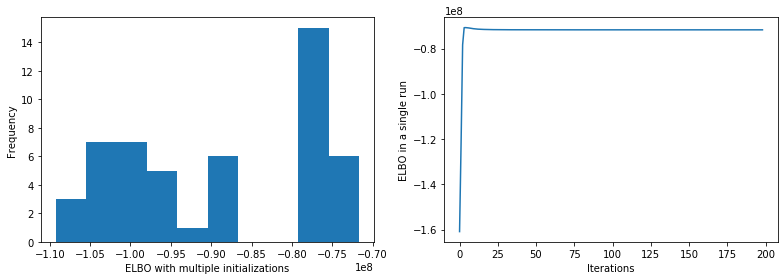

In [13]:
modelCA = run_vireo(AD, DP, N_DONORS, n_cores=32, plot_qc=True,out_f=join(OUTDIR, "donors"))
doublet_prob = modelCA.predict_doublet(AD, DP, update_GT=False, update_ID=False)[0].sum(axis=1)

Clustering


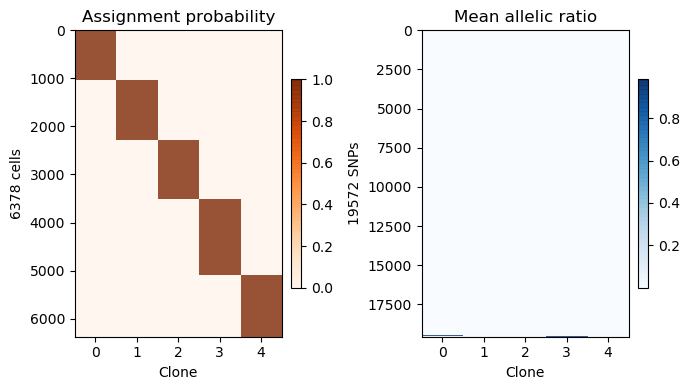

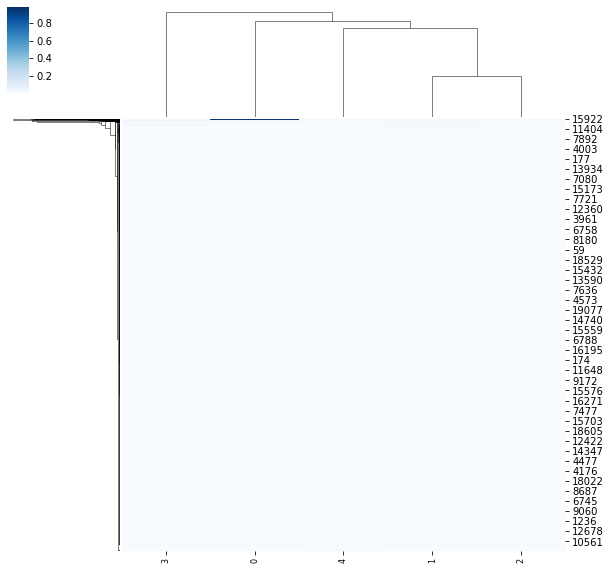

In [14]:
plot_vireo_out(modelCA, out_f=join(OUTDIR, "donors"), to_sqrt=False, labels=None,
                   doublet_prob=0.9)

## Extract donors

In [15]:
cell_clusters = extract_clusters(modelCA, prob_thresh=0.9, doublet_thresh=0.9, doublet_prob=doublet_prob,
                                 sample_colors=None, outdir=OUTDIR, out_f="donors")
cell_clusters

{0: array([   4,    6,   12,   19,   36,   42,   46,   47,   50,   54,   55,
          58,   61,   69,   75,   76,   80,   84,   89,   92,   93,   98,
         101,  102,  104,  106,  110,  113,  114,  115,  120,  121,  122,
         123,  126,  141,  143,  146,  151,  161,  167,  168,  169,  180,
         185,  186,  192,  193,  194,  196,  201,  206,  209,  213,  215,
         224,  231,  232,  233,  237,  241,  242,  246,  249,  251,  256,
         257,  260,  261,  270,  271,  273,  275,  276,  281,  299,  301,
         302,  309,  313,  315,  321,  322,  331,  338,  342,  349,  354,
         355,  360,  372,  373,  375,  376,  377,  378,  383,  384,  389,
         393,  396,  398,  399,  404,  422,  425,  434,  435,  436,  438,
         439,  449,  451,  458,  459,  461,  466,  471,  473,  475,  479,
         486,  491,  498,  509,  510,  511,  521,  522,  525,  530,  538,
         547,  552,  553,  558,  571,  572,  576,  577,  580,  581,  583,
         584,  585,  590,  600,  60

In [16]:
%matplotlib inline
run_elbo(AD, DP, out_f=join(OUTDIR, "donors_elbo"), n_clone_list=np.arange(N_DONORS-2, N_DONORS+3), 
         n_cores=12, sample_colors=None, save_clusters=False)

lineages 3
lineages 4
lineages 5
lineages 6
lineages 7


([], array([3, 4, 5, 6, 7]))

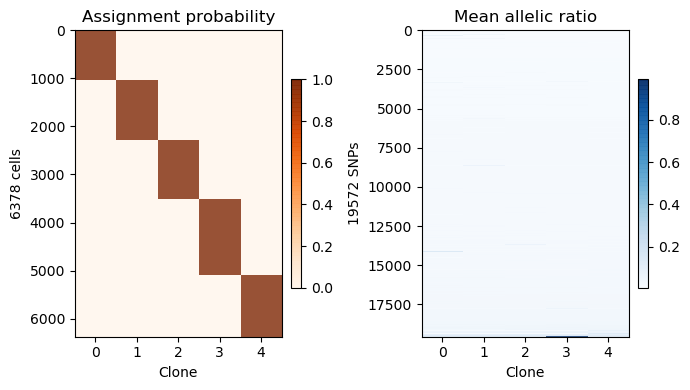

In [21]:
#fig = plt.figure(figsize=(7, 4), dpi=100)
f, ax = plt.subplots(figsize=(7, 4), dpi=100, nrows=2,ncols=2)
plt.subplot(1, 2, 1)
im = heat_matrix(modelCA.ID_prob, cmap="Oranges", alpha=0.8,
                 display_value=False, row_sort=True)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.title("Assignment probability")
plt.xlabel("Clone")
plt.ylabel("%d cells" % (modelCA.n_cell))
plt.xticks(range(modelCA.n_donor))

plt.subplot(1, 2, 2)
AF_SNPs = np.sum(
    modelCA.GT_prob * np.expand_dims(modelCA.beta_mu, 1), axis=2)


# f = plt.figure()
im = heat_matrix(np.sqrt(AF_SNPs), cmap="Blues", alpha=0.8,
                 display_value=False, row_sort=True)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.title("Mean allelic ratio")
plt.xlabel("Clone")
plt.ylabel("%d SNPs" % (modelCA.n_var))
plt.xticks(range(modelCA.n_donor))
plt.tight_layout()
#plt.savefig(out_f)
#plt.close()

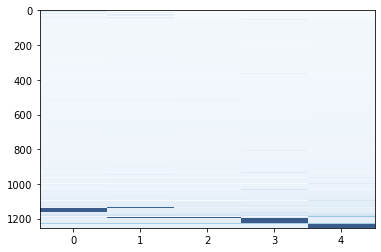

In [29]:
f = plt.figure()
im = heat_matrix(np.sqrt(AF_SNPs[(AF_SNPs.sum(axis=1)>0.01),:]), cmap="Blues", alpha=0.8,
                 display_value=False, row_sort=True)

## Separate for each sample before